## Setup

In [2]:
import os
from PIL import Image
import shutil
from batchgenerators.utilities.file_and_folder_operations import *
import numpy as np
import matplotlib.pyplot as plt
import glob

### Dataset Setup

In [2]:
# Dataset structure setup
source_directory = './data/'
destination_directory = './data/nnUNet_data/Dataset001_ISIC2018'

counter = 0
for filename in os.listdir(source_directory + 'ISIC2018_Task1-2_Training_Input'):
    if filename.split('.')[1] == 'jpg':
        train_file_name = 'isic_' + str(counter).zfill(4) + '_0000.png'
        train_destination_file = os.path.join(destination_directory, 'imagesTr', train_file_name)
        with Image.open(os.path.join(source_directory + 'ISIC2018_Task1-2_Training_Input', filename)) as img:
            img.save(train_destination_file, 'PNG')
        test_file_name = filename.split('.')[0] + '_segmentation.png'
        test_destination_file = os.path.join(destination_directory, 'labelsTr', 'isic_' + str(counter).zfill(4) + '.png')
        shutil.copy(source_directory + 'ISIC2018_Task1_Training_GroundTruth/' + test_file_name, test_destination_file)
        counter += 1

In [2]:
# Test files structure setup
source_directory = './data/'
destination_directory = './data/nnUNet_data/Dataset001_ISIC2018'

counter = 0
for filename in os.listdir(source_directory + 'ISIC2018_Task1-2_Test_Input'):
    if filename.split('.')[1] == 'jpg':
        test_file_name = 'isic_' + str(counter).zfill(4) + '_0000.png'
        test_destination_file = os.path.join(destination_directory, 'imagesTe', test_file_name)
        with Image.open(os.path.join(source_directory + 'ISIC2018_Task1-2_Test_Input', filename)) as img:
            img.save(test_destination_file, 'PNG')
        gt_file_name = filename.split('.')[0] + '_segmentation.png'
        gt_destination_file = os.path.join(destination_directory, 'labelsTe', 'isic_' + str(counter).zfill(4) + '.png')
        shutil.copy(source_directory + 'ISIC2018_Task1_Test_GroundTruth/' + gt_file_name, gt_destination_file)
        counter += 1

In [8]:
# Labels setup
source_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsTr_255'
destination_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsTr'
for filename in os.listdir(source_directory):
    label_image = Image.open(os.path.join(source_directory, filename))
    label_array = np.array(label_image)
    transformed_label_array = label_array // 255
    transformed_label_image = Image.fromarray(transformed_label_array.astype(np.uint8))
    transformed_label_image.save(os.path.join(destination_directory, filename))

## My UNet

In [ ]:
# Code for training the model
/home/leo/anaconda3/envs/MI-project/bin/python /home/leo/MI_project/myUNet_train.py

In [5]:
class myTestData(object):
    def __init__(self, root, transforms = None):
        self.root = root
        self._eval = eval
        self.transforms = transforms
        self.build_dataset()
        
    def build_dataset(self):   
        self.imgs = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "imagesTs")
        self.masks = os.path.join(self.root, "nnUNet_data", "Dataset001_ISIC2018", "labelsTs")
        
        self._images = sorted(glob.glob(self.imgs + "/*.png"))
        
#       Note: Here we are using only left lung data today
        self._labels = sorted(glob.glob(self.masks  + "/*.png"))
        
    def __getitem__(self, idx):
    
        img = Image.open(self._images[idx]).convert("RGB").resize((256,256), resample=0)
        mask = Image.open(self._labels[idx]).convert("L").resize((256, 256), resample=0)
        mask = Image.fromarray(((np.asarray(mask)).astype('float32')).astype('uint8'))
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
   
        return img, mask
    
    def __len__(self):
        return len(self._images)

In [6]:
# Code for evaluating the model
from myUNet_utils import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckptFileName = 'UNet_CKPT_best.pt'
# load the saved weights
model = UNet(channel_in=3, channel_out= 1).to(device)
model.load_state_dict(torch.load(ckptFileName))

transform = transforms.Compose([transforms.ToTensor()])
# transforms.Resize((256,256))
testset = myTestData(root='./data', transforms=transform)
testdataloader = DataLoader(testset)

# Apply testing (same as validation above)
# Your code here... (same as validation code)
test_dsc = []

with torch.no_grad():
    for i, (data, label) in enumerate(testdataloader):
        data_image = data.squeeze().permute(1, 2, 0).numpy()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'data_' + str(i) + '.png')), data_image)
        label_image = label.squeeze().numpy()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'label_' + str(i) + '.png')), label_image, cmap='gray')
        data, label = data.to(device), label.to(device)
        out = model(data)
        probabilities = torch.sigmoid(out)
        threshold = 0.5
        binary_mask = probabilities > threshold
        grayscale_mask = binary_mask.float() * 255
        grayscale_mask = grayscale_mask.byte()
        pred_label_image = grayscale_mask.cpu().detach().numpy().squeeze()
        plt.imsave(os.path.join(os.path.join('./myUNet_pe', 'pred_' + str(i) + '.png')), pred_label_image, cmap='gray')
        acc_1 = get_dice_arr(grayscale_mask, label.to(device))

        # append
        test_dsc.append(acc_1.mean(axis=0).detach().cpu().numpy())

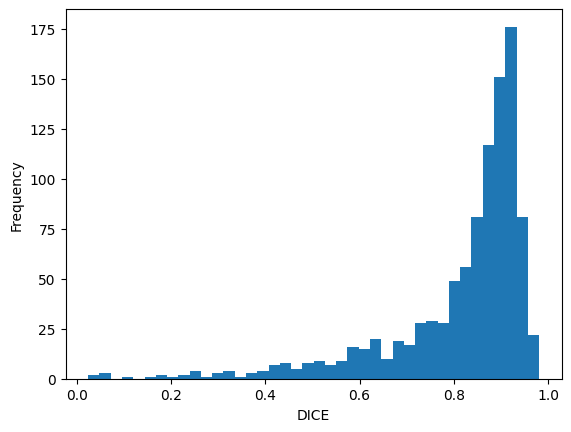

0.8134436

In [17]:
test_dsc = np.array(test_dsc).reshape(1, -1)[0]
plt.hist(test_dsc, bins=40)
plt.xlabel('DICE')
plt.ylabel('Frequency')
plt.show()
np.mean(test_dsc)

## nnUNet V2

In [ ]:
# After setting up the dataset, run below to train the model
export nnUNet_raw="/home/leo/MI_project/data/nnUNet_data"
export nnUNet_preprocessed="/home/leo/MI_project/data/nnUNet_preprocessed"
export nnUNet_results="/home/leo/MI_project/data/nnUNet_results"
export nnUNet_n_proc_DA=18

nnUNetv2_plan_and_preprocess -d 001 --verify_dataset_integrity

nnUNetv2_train 001 2d 0 --npz
nnUNetv2_train 001 2d 1 --npz
nnUNetv2_train 001 2d 2 --npz
nnUNetv2_train 001 2d 3 --npz
nnUNetv2_train 001 2d 4 --npz

In [ ]:
# Code to run the prediction
nnUNetv2_find_best_configuration 001 -c 2d
nnUNetv2_predict -i ./data/nnUNet_data/Dataset001_ISIC2018/imagesTs -o ./data/nnUNet_data/Dataset001_ISIC2018/labelsPe -d 001 -c 2d --save_probabilities

In [3]:
# Code to visualise the prediction
source_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsPe'
destination_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsPe_255'
for filename in os.listdir(source_directory):
    if filename.split('.')[1] == 'png':
        label_image = Image.open(os.path.join(source_directory, filename))
        label_array = np.array(label_image)
        transformed_label_array = label_array * 255
        transformed_label_image = Image.fromarray(transformed_label_array.astype(np.uint8))
        transformed_label_image.save(os.path.join(destination_directory, filename))

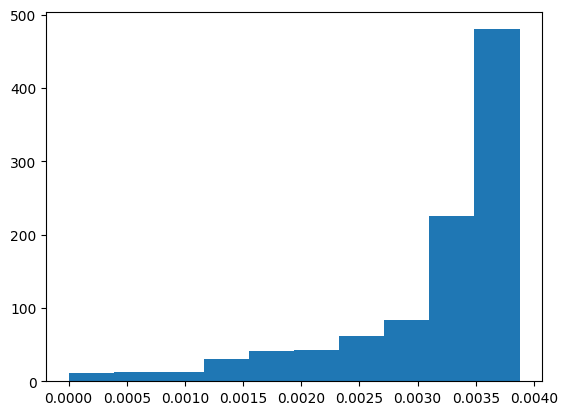

In [4]:
# Code to compare the DICE on the test set
def dice_coefficient(ground_truth, prediction):
    # Calculate intersection
    intersection = np.sum(ground_truth * prediction)
    # Calculate the sum of the ground truth and prediction arrays
    gt_sum = np.sum(ground_truth)
    pred_sum = np.sum(prediction)
    # Calculate Dice coefficient
    dice = (2. * intersection) / (gt_sum + pred_sum)
    return dice

# Example usage
pred_file_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsPe_255'
gt_file_directory = './data/nnUNet_data/Dataset001_ISIC2018/labelsTs'
dice_score = []
for filename in os.listdir(gt_file_directory):
    gt_image = Image.open(os.path.join(gt_file_directory, filename))
    gt_array = np.array(gt_image)
    pred_image = Image.open(os.path.join(pred_file_directory, filename))
    pred_array = np.array(pred_image)
    dice_score .append(dice_coefficient(gt_array, pred_array))

plt.hist(dice_score)
plt.show()

## MedSegDiff

In [ ]:
# After setting up the dataset, run below to train the model
python scripts/segmentation_train.py --data_name ISIC2018 --data_dir ../data/MedSegDiff/ISIC2018_Task1-2_Training_Input --out_dir ../data/MedSegDiff/train_results --image_size 256 --num_channels 128 --class_cond False --num_res_blocks 2 --num_heads 1 --learn_sigma True --use_scale_shift_norm False --attention_resolutions 16 --diffusion_steps 1000 --noise_schedule linear --rescale_learned_sigmas False --rescale_timesteps False --lr 1e-4 --batch_size 16
python scripts/segmentation_env.py --inp_pth ../data/MedSegDiff/ISIC2018_Task1-2_Test_Input --out_pth ../data/MedSegDiff/test_results


## Image Used for Presentation

(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)


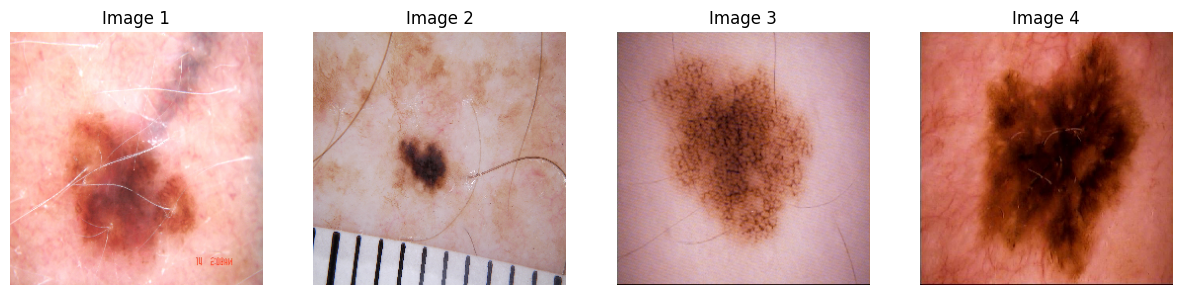

In [23]:
# For image plots
image_paths = ['./myUNet_pe/data_0.png', './myUNet_pe/data_1.png', './myUNet_pe/data_4.png', './myUNet_pe/data_3.png']
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))
for i, image_path in enumerate(image_paths):
    # Open the image
    img = Image.open(image_path)
    
    # Display the image
    axs[i].imshow(img)
    
    # Remove axis ticks
    axs[i].axis('off')
    
    # Optional: Set a title for each subplot
    axs[i].set_title(f'Image {i+1}')

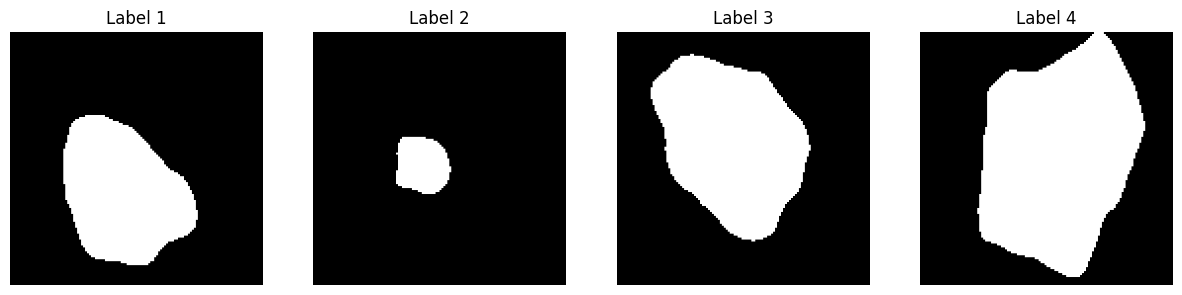

In [21]:
# For label plots
image_paths = ['./myUNet_pe/label_0.png', './myUNet_pe/label_1.png', './myUNet_pe/label_4.png', './myUNet_pe/label_3.png']
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))
for i, image_path in enumerate(image_paths):
    # Open the image
    img = Image.open(image_path)
    
    # Display the image
    axs[i].imshow(img)
    
    # Remove axis ticks
    axs[i].axis('off')
    
    # Optional: Set a title for each subplot
    axs[i].set_title(f'Label {i+1}')

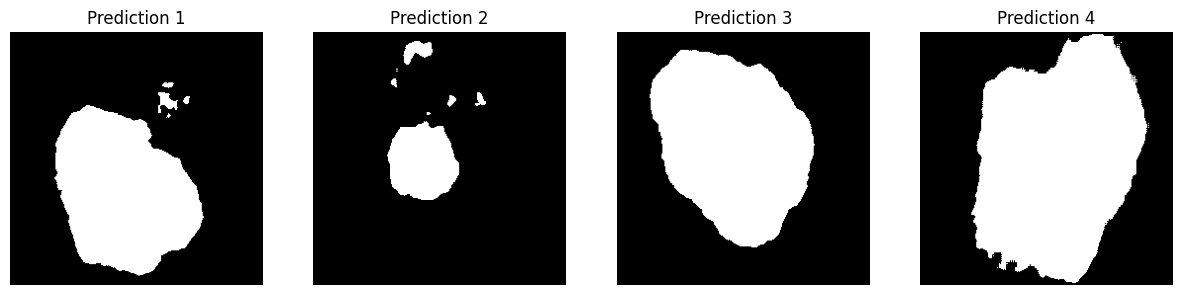

In [22]:
# For pred plots
image_paths = ['./myUNet_pe/pred_0.png', './myUNet_pe/pred_1.png', './myUNet_pe/pred_4.png', './myUNet_pe/pred_3.png']
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))
for i, image_path in enumerate(image_paths):
    # Open the image
    img = Image.open(image_path)
    
    # Display the image
    axs[i].imshow(img)
    
    # Remove axis ticks
    axs[i].axis('off')
    
    # Optional: Set a title for each subplot
    axs[i].set_title(f'Prediction {i+1}')